In [2]:
import numpy as np
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Import additional libraries: 
from matplotlib import cm
import sympy as sm
from sympy import *
from scipy import optimize
from scipy import interpolate

#KRÆVER INSTALLATION MED pip install tabulate
from tabulate import tabulate

# The logit model

In [13]:
# Data generating process
def DGP(mp):
    ''' The data generating process behind binary choice model
    
    Args:
        mp (SimpleNamespace): object containing parameters for data generation
    
    Returns:
        y_obs (ndarray): indicator for binary choices made by individuals
        x_obs (ndarray): independent variables 
    
    '''

    # a. Exogenous variables
    x0 = np.tile(1.0, mp.N)
    x1 = np.random.normal(**mp.x1_distr)
    x2 = np.random.normal(**mp.x2_distr)
    x_obs = np.vstack((x0, x1, x2)).T
    eps = np.random.logistic(0,1,mp.N)

    # b. Probabilities of action choice 
    y_prb = np.exp(x_obs @ mp.beta) / (1 + np.exp(x_obs @ mp.beta))

    # c. Draw binary choices from the binomial distribution 
    y_obs = np.random.binomial(1, y_prb)
    return y_obs, x_obs, eps

# Parameters
mp = SimpleNamespace()
mp.beta = np.array([0.15, 0.1, 0.2])
mp.N = 100000
mp.x1_distr = {'loc': 4, 'scale': 3, 'size': mp.N}
mp.x2_distr = {'loc': 1, 'scale': 0.5, 'size': mp.N}

# Create data
np.random.seed(2021)
y_obs, x_obs, eps = DGP(mp)

**Question 1.1**

In [5]:
def log_likelihood(beta, y_obs, x_obs):
    ''' Log-likelihood as a function of parameters 
    
    Args:
        beta (ndarray): array of paramters
        y_obs (ndarray): indicator for binary choices made by individuals
        x_obs (ndarray): independent variables 
    
    Returns:
        log_likeli (float): log-likelihood value
    
    '''
    
    prob = beta[0]*x_obs[:,0] + beta[1]*x_obs[:,1] + beta[2]*x_obs[:,2]
    y_prb = np.exp(prob) / (1 + np.exp(prob))
    
    return y_obs@np.log(y_prb) + (1-y_obs)@np.log(1-y_prb)

In [6]:
beta = np.array([0.15, 0.1, 0.2])
print(f'True parameters yield the log-likelihood value of {log_likelihood(beta, y_obs, x_obs):.4f}')

True parameters yield the log-likelihood value of -62082.1327


**Question 1.2**

**Question 1.3**

In [7]:
def log_likelihood_obj(beta, y_obs, x_obs):
    ''' returns the negative of the log likelihood value in order to perform maximum likelihood estimation by minimizing '''
    return -log_likelihood(beta, y_obs, x_obs)

In [8]:
#maximum likelihood estimates are computed using the gradient-free 'Nelder-Mead' approach.
def MLE(y_obs, x_obs, betas0):
    '''' Maximum likelihood estimates
    
    Args:
    betas0 (ndarray):
    y_obs (ndarray): indicator for binary choices made by individuals
    x_obs (ndarray): independent variables 
    
    Returns:
    betas (ndarray): maximum likelihood estimates
    
    '''
    
    sol = optimize.minimize(log_likelihood_obj,betas0,args=(y_obs,x_obs),method='Nelder-Mead')
    betas = sol.x
    return betas

In [9]:
betas0 = np.array([0.5,0.5,0.5])
betas = MLE(y_obs, x_obs, betas0)
print(f'Maximum likelihood estimates are:')
for i,beta in enumerate(betas):
    print(f'beta{i}hat = {beta:.4f}')

Maximum likelihood estimates are:
beta0hat = 0.1591
beta1hat = 0.0969
beta2hat = 0.1987


**Question 1.4**

In [14]:
#Calculate ystar. Epsilon is added to the initial DGP
ystar = betas[0]* x_obs[:,0] + betas[1] * x_obs[:,1] + betas[2] * x_obs[:,2] + eps

#Initiate dictionary for each category (True,True), (True,False), (False,True) (False,False)
start_dict = {"tt": 0, "tf": 0, "ft": 0, "ff": 0}

#Loop over all observations to determine distribution
for i in range(0,mp.N):
    
    if y_obs[i] == 1 and ystar[i]>0:
        start_dict["tt"] += 1
    elif y_obs[i] == 1 and ystar[i]<=0:
        start_dict["tf"] += 1
    elif y_obs[i] == 0 and ystar[i]>0:
        start_dict["ft"] += 1
    elif y_obs[i] == 0 and ystar[i]<=0:
        start_dict["ff"] += 1

#We print our results as a table in order to determine the distribution for each group.
print(tabulate([["y_obs=1, y_sim=1",start_dict['tt']],["y_obs=1, y_sim=0",start_dict['tf']],
["y_obs=0, y_sim=1",start_dict['ft']],["y_obs=0, y_sim=0",start_dict['ff']]], 
headers = ["Statistics Group","Count"])) 

Statistics Group      Count
------------------  -------
y_obs=1, y_sim=1      46155
y_obs=1, y_sim=0      21309
y_obs=0, y_sim=1      21556
y_obs=0, y_sim=0      10980


From the above distribution, it is clear that in 46155 of the cases both y_star and y_obs result in the agent taking the action. In about 21000 of the cases, either y_star or y_obs returns 1, while the other dosent. Finally in around 11% of the cases both y_star and y_obs will result in the individual not making the choice.

**Question 1.5**

Evidently, the initial guess of $\beta$ is important for whether the MLE function succeeds in returning actual estimates. As shown below, providing the initial guess, $\beta = (\beta_0, \beta_1, \beta_2)' = (5,5,5) $, renders a mistake.

In [15]:
betas0 = np.array([5,5,5])
betas = MLE(y_obs, x_obs, betas0)
print(f'Maximum likelihood estimates are:')
for i,beta in enumerate(betas):
    print(f'beta{i}hat = {beta:.4f}')

<ipython-input-5-992187c99732>:17: RuntimeWarning: divide by zero encountered in log
  return y_obs@np.log(y_prb) + (1-y_obs)@np.log(1-y_prb)
<ipython-input-5-992187c99732>:17: RuntimeWarning: invalid value encountered in matmul
  return y_obs@np.log(y_prb) + (1-y_obs)@np.log(1-y_prb)


Maximum likelihood estimates are:
beta0hat = 5.0000
beta1hat = 5.0000
beta2hat = 5.0000


# Consumption saving with borrowing

In [16]:
#Parameters
rho = 3
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.95
Delta = 0.5

#Dictionary:
p_low_dict = {1: 0.9, 2:0.1}

**Question 2.1**

In [17]:
#defining basic functions of the model
def utility(c,rho):
    """"
    Estimates the basic utility function for a given consumption level
    
    Args:
    c (float): consumption in current period
    rho (float): is the risk aversion coefficient

    Returns:
    util(float): utility in a given period
    """
    return c**(1-rho)/(1-rho)


def v2(c2, m2, nu, kappa, rho):
    """
    Returns value of choice in period 2
    
    Args:
    c2 (float): is consumption in the second period
    m2 (float): cash-on-hand in the beginning of second period
    nu (float): is the strength of the bequest motive
    kappa (float): is the degree of luxuriousness in the bequest motive
    rho (float): is the risk aversion coefficient

    Returns: 
    v2 (float): value of choice in period 2
    """
    return utility(c2, rho) + nu*(m2-c2+kappa)**(1-rho)/(1-rho)


def v1(c1, m1, nu, kappa, rho, r, Delta, p_low, v2_interp):
    """
    Returns value of choice in period 1
    
    Args:
    c1 (float): is consumption in the first period
    m1 (float): cash-on-hand in the beginning of the first
    nu (float): is the strength of the bequest motive
    kappa (float): is the degree of luxuriousness in the bequest motive
    rho (float): is the risk aversion coefficient
    r (float): is the interest rate
    Delta (float): is the level of income risk
    p_low (float): is the chance the given household type get a low income in the next period
    v2_interp (array): Interpolation of v2 function


    Returns: 
    v1 (float): total utility value in period 1
    """
    
    # Value of v2 if low income
    m2_low = (1+r)*(m1-c1) + (1-Delta)
    v2_low = v2_interp([m2_low])[0]
    
    # Value of v2 if high income
    m2_high = (1+r)*(m1-c1) + (1+Delta)
    v2_high = v2_interp([m2_high])[0]
    
    #Expected value of v2
    v2 = p_low*v2_low + (1-p_low)*v2_high

    #Return the total value
    return utility(c1,rho) + beta*v2

In [18]:
#Defining solver for period 2
def solve_period_2(nu, kappa, rho):
    """
    Returns value of choice in period 1
    
    Args:
    nu (float): is the strength of the bequest motive
    kappa (float): is the degree of luxuriousness in the bequest motive
    rho (float): is the risk aversion coefficient
    
    Returns: 
    m2_vec (array): Vector of m2 values
    v2_vec (array): Vector of optimal values for v2
    c2_vec (array): Vector of optimal consumption values in period 2
    """
    # a. vectors
    m2_vec = np.linspace(1e-8,5,500)
    c2_vec = np.empty(500)
    v2_vec = np.empty(500)
    
    
    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

            # i. objective
            obj = lambda x: -v2(x[0],m2,nu,kappa,rho)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

            # iv. save
            v2_vec[i] = -result.fun
            c2_vec[i] = result.x[0]
        
    return m2_vec,v2_vec, c2_vec

In [19]:
#Defining solver for period 1
def solve_period_1(nu, kappa, rho, r, Delta, p_low, v1, v2_interp):
    """
    Returns the optimal value v1 and choice of c1 for each m1 in period 1
    
    Args:
    nu (float): is the strength of the bequest motive
    kappa (float): is the degree of luxuriousness in the bequest motive
    rho (float): is the risk aversion coefficient
    r (float): is the interest rate
    Delta (float): is the level of income risk
    p_low (float): is the chance the given household type get a low income in the next period
    v1 (array): Vector of optimal consumption values in period 1
    v2_interp (array): Interpolation of v2 function


    Returns: 
    m1_vec (array): Vector of m1 values
    v1_vec (array): Vector of optimal values for v1
    c1_vec (array): Vector of optimal consumption values in period 1
    """
    
    # a. vectors
    m1_vec = np.linspace(1e-8,5,500)
    c1_vec = np.empty(500)
    v1_vec = np.empty(500)
    
    
    # b. solve for each m2 in grid
    for i,m1 in enumerate(m1_vec):

            # i. objective
            obj = lambda x: -v1(x[0],m1,nu,kappa,rho, r, Delta, p_low, v2_interp)

            # ii. initial value (consume half)
            x0 = m1/2

            # iii. optimizer
            result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,(1-Delta)/(1+r)+m1),))

            # iv. save
            v1_vec[i] = -result.fun
            c1_vec[i] = result.x[0]
        
    return m1_vec, v1_vec, c1_vec

In [20]:
#Defining a 'total' solver to run all components at once
def solve(nu,kappa,rho,r,Delta,p_low,v1):
    """
    Returns the optimal values and consumption in both periods
    
    Args:
    nu (float): is the strength of the bequest motive
    kappa (float): is the degree of luxuriousness in the bequest motive
    rho (float): is the risk aversion coefficient
    r (float): is the interest rate
    Delta (float): is the level of income risk
    p_low (float): is the chance the given household type get a low income in the next period
    v1 (array): Vector of optimal consumption values in period 1


    Returns: 
    m2_vec (array): Vector of m2 values
    v2_vec (array): Vector of optimal values for v2
    c2_vec (array): Vector of optimal consumption values in period 2
    m1_vec (array): Vector of m1 values
    v1_vec (array): Vector of optimal values for v1
    c1_vec (array): Vector of optimal consumption values in period 1
    """
    
    #a. Initially solve period 2
    m2_vec, v2_vec, c2_vec = solve_period_2(nu, kappa, rho)
    
    #b. Interpolate 
    v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    #c. Solve for period 1
    m1_vec, v1_vec, c1_vec = solve_period_1(nu, kappa, rho, r, Delta, p_low, v1, v2_interp)
    
    return m2_vec, v2_vec, c2_vec, m1_vec, v1_vec, c1_vec

With all the components, we can now plot our value function v_i(m_i)

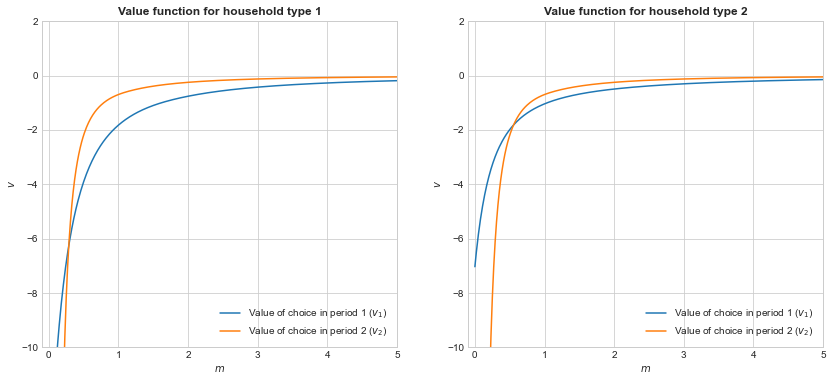

In [21]:
#Iterate over each household type and plot both

#Initiate figure
fig = plt.figure(figsize=(14,6))

#Create subplot for each household type
for x, y in p_low_dict.items():
    #Solve function for given household type, defined by p_low
    m2_vec, v2_vec, c2_vec, m1_vec, v1_vec, c1_vec = solve(nu,kappa,rho,r,Delta, y ,v1)
    
    #Create figure
    ax = fig.add_subplot(1,2,x)
    
    #Add both lines
    ax.plot(m1_vec,v1_vec, label="Value of choice in period 1 ($v_1$)")
    ax.plot(m2_vec,v2_vec, label="Value of choice in period 2 ($v_2$)")
    
    #Formating 
    ax.legend(loc='lower right')
    ax.set_xlabel('$m$')
    ax.set_ylabel('$v$')
    ax.set_title(f'Value function for household type {x}', fontweight='bold')
    ax.set_xlim([-0.1,5])
    ax.set_ylim([-10,2]);
    
plt.show()

We observe from the figures, that both households have the same value of choice in period 2. This is as there is not anything stochastic in this period, so they will both make the same choices at a given income level. In period 1 household type 1 will have a lower value for each income level, as they are more likely to have a lower income in the next period. It is therefore intutitive that their value is looking from this period, is lower as well.

**Question 2.2**

As we in the Question 1 maximized the value for each period and level of cash-on-hand, it is clear that the accompanigning consumption level will be the optimal consumption. We can therefore simply call our solve function, this time plotting consumption instead of value.

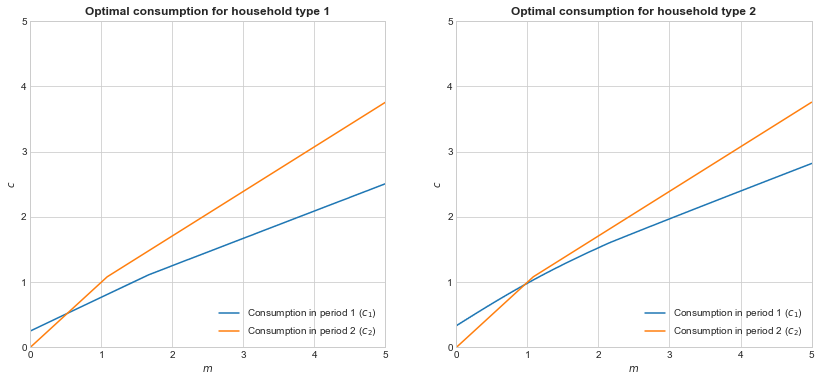

In [25]:
#Initiate figure
fig = plt.figure(figsize=(14,6))

#Iterate over each household type and plot both
for x, y in p_low_dict.items():
    #Solve function for given household type, defined by p_low
    m2_vec, v2_vec, c2_vec, m1_vec, v1_vec, c1_vec = solve(nu,kappa,rho,r,Delta, y,v1)
    
    #Create figure
    ax = fig.add_subplot(1,2,x)
    ax.plot(m1_vec,c1_vec, label="Consumption in period 1 ($c_1$)")
    ax.plot(m2_vec,c2_vec, label="Consumption in period 2 ($c_2$)")
    ax.legend(loc='lower right')
    ax.set_xlabel('$m$')
    ax.set_ylabel('$c$')
    ax.set_title(f'Optimal consumption for household type {x}', fontweight='bold')
    ax.set_xlim([0,5])
    ax.set_ylim([0,5]);
    
plt.show()

As in Question 2.1, it is clear that consumption in period 2, is the same for both household types. This is due to the same reason, of nothing being stochastic in this period.
Similarily, we see the same pattern in period 1, where household type 1 will consume less at a given level of cash-on-hand than household type 2. This is due to the insecurity of the next period, where they are aware that they are more inclined to have a lower income than household type 2.

**Question 2.3**

We write a program, which will simulate and calculate the fractions of households that will borrow in the first period. Furthermore the program also outputs a histogram showing the distribution of c1 and a1, for the simulated households.

In [30]:
#Count total number of households, to ensure our observations are correct
def frac_borrow(nu,kappa,rho,r,Delta, p_low,v1):
    """
    Returns the fraction of households spending more than their cash-on-hand in p1 as well as optimal consumption 
    and alpha for p1
    
    Args:
    nu (float): is the strength of the bequest motive
    kappa (float): is the degree of luxuriousness in the bequest motive
    rho (float): is the risk aversion coefficient
    r (float): is the interest rate
    Delta (float): is the level of income risk
    p_low (float): is the chance the given household type get a low income in the next period
    v1 (array): Vector of optimal consumption values in period 1


    Returns: 
    frac (float): Fraction of households borrowing in p1
    sim_c1 (array): Vector of optimal values for consumption in period 1
    c2_vec (array): Vector of alpha values in period 1

    """
    #Solve model
    m2_vec, v2_vec, c2_vec, m1_vec, v1_vec, c1_vec = solve(nu,kappa,rho,r,Delta, p_low,v1)
    
    #Interpolate period 1
    c1_interp = interpolate.RegularGridInterpolator([m1_vec], c1_vec,
                                                bounds_error=False,fill_value=None)
    
    #DGP:
    np.random.seed(2021)
    simN = 1000
    # No one gets negative m in first period
    sim_m1 = np.fmax(np.random.normal(1, 1, size = simN), 0)
    
    # b. period 1
    sim_c1 = c1_interp(sim_m1)
    sim_a1 = sim_m1-sim_c1
    
    #Count amount of households that borrow
    borrow = (sim_a1<0).sum()
    frac = borrow / simN * 100
    
    #Calculate fraction
    return frac, sim_c1, sim_a1

Both of the p_low values are then looped over, in order to calculate the fraction of households who borrow for both types of households. Furthermore a historgram is created for each household type, showing the distribution of c1 and a1.

The fraction of households of type 1 who borrow in the first period is 33.6 %
The fraction of households of type 2 who borrow in the first period is 48.6 %


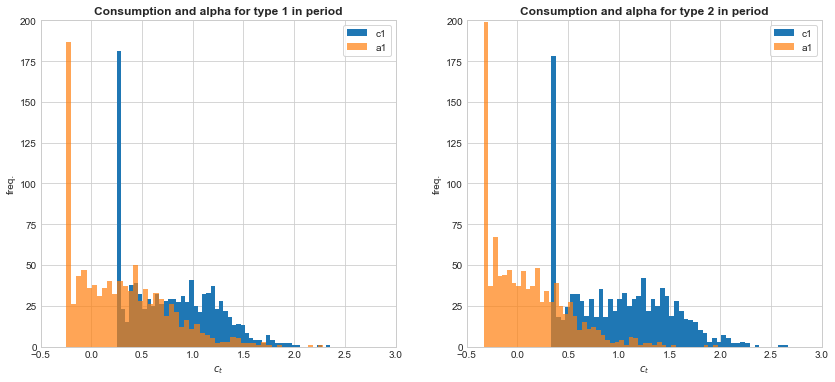

In [31]:
#Initiate figure
fig = plt.figure(figsize=(14,6))

for x, y in p_low_dict.items():
    #Solve function for given household type, defined by p_low
    frac, sim_c1, sim_a1 = frac_borrow(nu,kappa,rho,r,Delta, y,v1)
    
    #Print Fraction
    print(f"The fraction of households of type {x} who borrow in the first period is {frac} %")
    
    #Plot histogram (BONUS)
    ax = fig.add_subplot(1,2,x)

    ax.hist(sim_c1,bins=50,label='c1')
    ax.hist(sim_a1,bins=50,label='a1', alpha=0.7)

    ax.legend(loc='upper right',facecolor='white',frameon=True)
    ax.set_xlabel('$c_t$')
    ax.set_ylabel('freq.')
    ax.set_xlim([-0.5,3])
    ax.set_ylim([0,200]);
    ax.set_title(f'Consumption and alpha for type {x} in period', fontweight='bold');

# Division by Newton's method

**Question 3.1**

**Question 3.2**